# Install and Import Libraries
1. torch - PyTorch
2. torchtext - contains our dataset: AG_NEWS
3. portalocker - a library for Python file locking (to control access to files)

In [36]:
# to uncomment and run if you have not installed these libraries before:

# !pip install torch torchtext
# !pip install portalocker==2.8.2

In [37]:
import torch
import torchtext
from torchtext.datasets import AG_NEWS
torchtext.disable_torchtext_deprecation_warning()

# Prepare data processing pipelines
The dataset contains news articles categorized into four classes:  (1) World, (2) Sports, (3) Business, and (4) Sci/Tech.

<u>Raw data taken from torchtext/ag_news.py</u>:\
Training data: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv,
Testing data: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv

This first step processes raw data strings from dataset iterators. Dataset iterators, as the name suggests, iterates over your dataset, allowing you to access elements in a dataset one at a time.

In [38]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
# load training dataset
train_iter = AG_NEWS(split="train")

# tokenise text using basic English rules - split by space and punctuation
tokenizer = get_tokenizer("basic_english")

# create a function that iterates over data and yield tokenised text
def yield_tokens(data_iter):
    for _, text in data_iter: # ignores label (output) and only processes text
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
# `specials` arg: specifies tokens that represent out-of-vocab (unknown) words
# returns a Vocab object

# set default index of vocab (default value) to be index of <unk> token
vocab.set_default_index(vocab["<unk>"])

In [39]:
# converts a list of tokens into integers
vocab(['here', 'is', 'an', 'example'])

[475, 21, 30, 5297]

In [40]:
text_pipeline = lambda x: vocab(tokenizer(x))
# a function that takes in a sentence (str) and 
    # returns the associated integers for each word (list), using the vocab lookup table
label_pipeline = lambda x: int(x) - 1
# a function that takes in a label (str) and returns as an index (int)

In [41]:
text_pipeline('here is an example')

[475, 21, 30, 5297]

In [42]:
label_pipeline('10')

9

# Generate Data Batch and Iterator
To process batches according to the data processing pipelines declared previously.

In each data batch input, the text entries are packed into a list and concatenated as a single tensor for the input of `nn.EmbeddingBag`.

Within the loop (consisting of a batch), the `offsets` list keeps track of the starting index of each text sequence as they are concatenated into a single tensor. This is crucial when using models like `nn.EmbeddingBag`, which use offsets to efficiently handle variable-length sequences.

<u> An example to show what is happening in `offsets`</u>:\
In a batch of 3 text sequences with lengths 5, 3 and 4 respectively,\
offsets = [0,5,3,4]\
offsets[:-1] = [0,5,3]\
cumulative_sum = [0,5,8] -> starting positions of 3 text sequences

In [43]:
# to load data in batches
from torch.utils.data import DataLoader

# set device: use GPU (CUDA) is available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    # initialise lists to store labels, processed texts and offsets
    label_list, text_list, offsets = [], [], [0]
    
    for _label, _text in batch: # for each text sequence in the batch
        label_list.append(label_pipeline(_label))
        # create tensor objects
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        # append the length of processed text in both lists
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    # takes all elements except last
    # computes cumulative sum to get the start indexes of each sequence
    
    # concatenate text tensor
    text_list = torch.cat(text_list)
    # move tensors to device
    return label_list.to(device), text_list.to(device), offsets.to(device)

dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

# Define the Model
The model is composed of:
1. EmbeddingBag layer: converts sequences of word indices into fixed-size vectors

    For each sequence, `nn.EmbeddingBag` (a) looks up embeddings for each word index and (b) takes the average of embeddings to produce a vector (who's length is consistent across sequences). 

    Embedding is the representation of discrete data (like words) in a continuous vector space, i.e. converts high-dimensional categorical data into low-dimensional continuous vectors.
    
    The accumulation of average across embeddings enhances performance and memory efficiency to process a sequence of tensors.


2. Linear layer: uses aggregated embeddings to classify the class

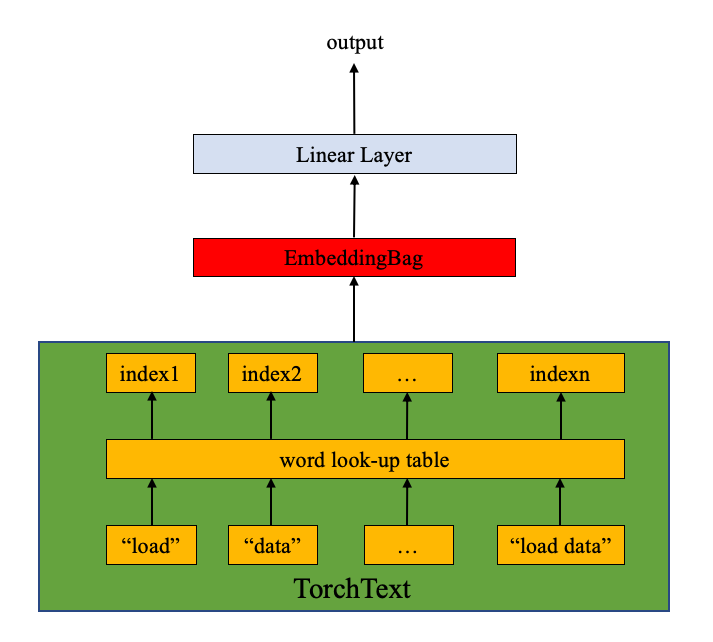

In order to build the neural networks, we use the `nn` module.

In [44]:
from torch import nn

# define a new class that inherits from nn.Module
class TextClassificationModel(nn.Module):
    # initialises the model - sets up 2 layers
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        # vocab_size: number of unique words
        # embed_dim: dimension of word embeddings
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)

        # fc = fully connected
        # embed_dim: dimension of input (output for embedding layer)
        # num_class: number of output classes for classification
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    # initialises weights of both layers
    def init_weights(self):
        initrange = 0.5
        # embedding and linear layer weights are initialised uniformly
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        # linear layer biases are initialised to zero
        self.fc.bias.data.zero_()

    # forward pass of model
    # text: batch of sequences represented as word indices
    # offsets: starting positions of each sequence in the batch
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

# Initiate an instance

In [45]:
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64 # embedding dimension
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

# Define functions to train model and evaluate results
## `train` function
- Handles one epoch of training, including forward pass, loss computation, backward pass and optimisation
- Also logs process at regular intervals

In [46]:
import time

def train(dataloader):
    # set model to training mode, enables training-specific features like dropout and batch normalisation
    model.train()
    # total accuracy, count of samples
    total_acc, total_count = 0, 0
    # logging interval
    log_interval = 500
    start_time = time.time()

    # iterate over DataLoader
    for idx, (label, text, offsets) in enumerate(dataloader):
        # clear previous gradients
        optimizer.zero_grad()
        # get predictions from the model
        predicted_label = model(text, offsets)
        # compute loss
        loss = criterion(predicted_label, label)
        # backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        # optimise
        optimizer.step()
        # update accuracy
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        # print training accuracy at intervals
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

## `evaluate` function
- Evaluates the model on validation or test data, and calculates accuracy

In [47]:
def evaluate(dataloader):
    # set model to evaluation mode, disables training-specific features like dropout and batch normalisation
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad(): # disable gradient calculation - reduces memory usage and speeds up computation
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

# Split the dataset and run the model
The original **AG_NEWS** has no validation dataset, so we split the training dataset into train/valid sets with a split ratio of 0.95 (train) and 0.05 (valid).

Loss funtion: **CrossEntropyLoss** - combines nn.LogSoftmax() and nn.NLLLoss(), used for multi-class classification.

Optimiser: **SGD** - stochastic gradient descent method.

In [48]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

# Hyperparameters - control the training process
EPOCHS = 10  # epoch
LR = 5  # learning rate
BATCH_SIZE = 64  # batch size for training

# loss function - combines Log Softmax and negative log likelihood loss
criterion = torch.nn.CrossEntropyLoss()
# optimiser: Stochastic Gradient Descent (SGD)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# reduces the learning rate by a factor of 0.1 if validation accuracy does not improve
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_iter, test_iter = AG_NEWS()
# converts iterators to map-style datasets
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

# prepares data for training, validation and testing with the specified batch size and shuffle option
train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

## Training Loop
Makes use of `train` and `evaluate` functions previously defined

In [49]:
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time() # records start time
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    # if total accuracy is not zero and 
    # current validation accuracy is worse than the previous best
    if total_accu is not None and total_accu > accu_val: 
        scheduler.step() # decrease learning rate
    else:
        total_accu = accu_val # otherwise, update validation accuracy
    print("-" * 59) # dashes
    print(
        "| end of epoch {:2d} | time: {:5.2f}s | " # 2-digit integer, float with 2dp
        "valid accuracy {:8.3f} ".format( # float with 3dp
            epoch, time.time() - epoch_start_time, accu_val
        )
    )
    print("-" * 59)


| epoch   1 |   500/ 1782 batches | accuracy    0.683
| epoch   1 |  1000/ 1782 batches | accuracy    0.855
| epoch   1 |  1500/ 1782 batches | accuracy    0.874
-----------------------------------------------------------
| end of epoch  1 | time: 26.81s | valid accuracy    0.876 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.896
| epoch   2 |  1000/ 1782 batches | accuracy    0.899
| epoch   2 |  1500/ 1782 batches | accuracy    0.903
-----------------------------------------------------------
| end of epoch  2 | time: 27.34s | valid accuracy    0.884 
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.912
| epoch   3 |  1000/ 1782 batches | accuracy    0.914
| epoch   3 |  1500/ 1782 batches | accuracy    0.916
-----------------------------------------------------------
| end of epoch  3 | time: 25.84s | valid accuracy    0.903 
----------------------------------

# Evaluate the model with test dataset

We are using the different metrics that we have covered in the slides.

In [50]:
from sklearn.metrics import classification_report

def predict(model, dataloader):
    # Set the model to evaluation mode
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        # Enumerate gives you the index and the data
        # e.g. (0, (label, text, offsets))
        for idx, (label, text, offsets) in enumerate(dataloader):
              # Unpack the data to get inputs and labels
            outputs = model(text, offsets)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(label.numpy())  # Collect the true labels
    return predictions, true_labels

def generate_accuracy(model, dataloader):
    # Get the predictions and true labels
    predictions, true_labels = predict(model, dataloader)

    # For accuracy, it's the number of correct predictions divided by all predictions
    correct = sum(predictions[i] == true_labels[i] for i in range(len(predictions)))
    accuracy = correct / len(predictions)

    print(f'Accuracy: {accuracy}')

    # return accuracy

def generate_classification_report(model, dataloader):
    # Get the predictions and true labels
    predictions, true_labels = predict(model, dataloader)

    # Generate the classification report from sklearn
    report = classification_report(true_labels, predictions)
    print(report) 

    # return report

# Test on the test dataset

In [51]:
generate_accuracy(model, test_dataloader)

Accuracy: 0.9082894736842105


In [52]:
generate_classification_report(model, test_dataloader)

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1900
           1       0.95      0.97      0.96      1900
           2       0.87      0.88      0.87      1900
           3       0.89      0.88      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



# Save Model

When we save the model, we are not saving the "model" itself. Instead, what we are saving instead are the weights of the model that we can utilise in our new app.py.

There will be other things that we will need to provide our model, so we will take these things according to what we need. 

In [53]:
def save_model(model, path='model.pth'):
    torch.save(model.state_dict(), path)

save_model(model)

In [54]:
# We will need this later
vocab_list = vocab.get_itos()
with open('vocab.txt', 'w') as f:
    for item in vocab_list:
        f.write(f"{item}\n")

# Hyperparameter Tuning
Due to its complexity, we decided to exclude it from our code. Here's some resources that show what you can do with different libraries!

Additonal libraries:
- [Scikitlearn (for non deep learning models!)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- [RayTune](https://docs.ray.io/en/latest/tune/getting-started.html)
- [Bayesian Optimization](https://botorch.org/)